# Dataset Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


rt if you dont like my tweets with my belief in jesus christ please respect it but dont mock it or make negative remarks8230


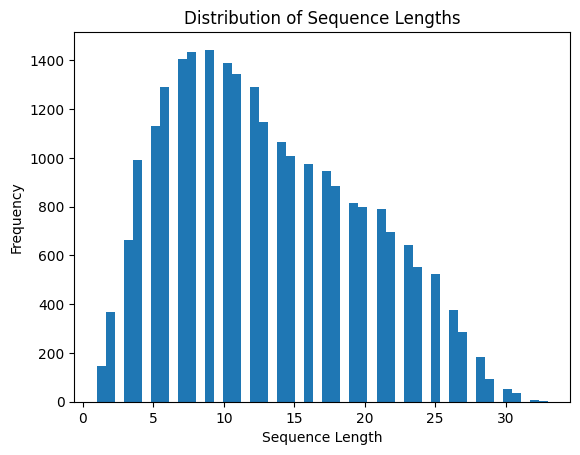

Chosen maximum length: 25


In [2]:
import re
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm


df = pd.read_csv('/content/drive/MyDrive/NLP_PJ/labeled_data.csv')
df.drop(columns=['count', 'hate_speech', 'offensive_language', 'neither'], inplace=True)

def preprocess_text(text):
    # Remove patterns like 'RT @username:' from the tweet and the trailing colon
    text = re.sub(r'!+\s*RT\s*@[\w_]+\s*:?\s*', '', text, flags=re.IGNORECASE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r':\s*', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Remove emojis (including unicode emojis like '&#128517;')
    text = re.sub(r'&#\d+;', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Convert tweet text to lowercase
    text = text.lower()
    # Remove extra whitespaces
    text = text.strip()
    return text

df['tweet'] = df['tweet'].apply(preprocess_text)
df = df[df['tweet'].str.len() > 2]

df.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

print(df['tweet'][15534])

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

import matplotlib.pyplot as plt

# Compute sequence lengths
sequence_lengths = [len(text.split()) for text in df['tweet']]

# Plot histogram
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

# Choose a percentile (e.g., 95th percentile)
percentile_value = 95
max_length = int(np.percentile(sequence_lengths, percentile_value))
print(f"Chosen maximum length: {max_length}")

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, data, max_seq_length):
        self.data = data
        self.max_seq_length = max_seq_length
        self.word_to_index = defaultdict(lambda: len(self.word_to_index) + 1)
        self.word_to_index['[UNK]'] = 0  # For unknown words
        self.category_to_index = {0: 'hate speech', 1: 'offensive language', 2: 'neither'}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        word_indices = [self.word_to_index.get(word, self.word_to_index['[UNK]']) for word in sample['tweet'].split()]
        category_index = int(sample['class'])  # Ensure it's an integer
        padding_length = self.max_seq_length - len(word_indices)
        word_indices += [0] * padding_length if padding_length > 0 else []

        return {
            'word_indices': torch.tensor(word_indices, dtype=torch.long),
            'category_index': torch.tensor(category_index, dtype=torch.long),
            'label': torch.tensor(category_index, dtype=torch.long)
        }

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0
        self.depth = d_model // num_heads

        self.WQ = nn.Linear(d_model, d_model)
        self.WK = nn.Linear(d_model, d_model)
        self.WV = nn.Linear(d_model, d_model)

        self.fc = nn.Linear(d_model, d_model)

    def forward(self, query, key, value):
        batch_size = query.size(0)

        query = self.WQ(query).view(batch_size, -1, self.num_heads, self.depth)
        key = self.WK(key).view(batch_size, -1, self.num_heads, self.depth)
        value = self.WV(value).view(batch_size, -1, self.num_heads, self.depth)

        query = query.permute(0, 2, 1, 3)
        key = key.permute(0, 2, 1, 3)
        value = value.permute(0, 2, 1, 3)

        scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.depth, dtype=torch.float32))
        attention_weights = F.softmax(scores, dim=-1)

        output = torch.matmul(attention_weights, value)
        output = output.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)

        return self.fc(output)

class SKSModel(nn.Module):
    def __init__(self, vocab_size, max_seq_length, num_categories, embedding_dim, num_heads, d_model, num_tasks):
        super(SKSModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.category_embedding = nn.Embedding(num_categories, embedding_dim)
        self.concat = nn.Linear(embedding_dim * 2, 64)
        self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
        self.gated_attention = nn.ModuleList([nn.Linear(d_model, 1) for _ in range(num_tasks)])
        self.output_layers = nn.ModuleList([nn.Linear(d_model, num_categories) for _ in range(num_tasks)])

    def forward(self, word_input, category_input):
        word_embedded = self.embedding(word_input)
        category_embedded = self.category_embedding(category_input)
        category_embedded = category_embedded.unsqueeze(1).expand(-1, word_embedded.size(1), -1)

        concatenated_embedded = torch.cat((word_embedded, category_embedded), dim=-1)
        concatenated_embedded = F.relu(self.concat(concatenated_embedded))

        attention_output = self.multi_head_attention(concatenated_embedded, concatenated_embedded, concatenated_embedded)
        gated_attention_outputs = [output_layer(torch.sigmoid(gate(attention_output)) * attention_output) for gate, output_layer in zip(self.gated_attention, self.output_layers)]

        pooled_output = attention_output.mean(dim=1)  # Global average pooling
        final_output = self.output_layers[0](pooled_output)  # Assuming a single task for simplicity
        return final_output

def collate_batch(batch):
    word_indices = [item['word_indices'] for item in batch]
    category_indices = [item['category_index'] for item in batch]
    labels = [item['label'] for item in batch]

    word_indices_padded = pad_sequence(word_indices, batch_first=True, padding_value=0)
    category_indices = torch.tensor(category_indices, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.long)

    return {'word_indices': word_indices_padded, 'category_index': category_indices, 'label': labels}

# Example usage
vocab_size = 10000
num_categories = 3
embedding_dim = 100
num_heads = 4
d_model = 64
num_tasks = 3
batch_size = 16

# Assuming you have train_data and val_data available
train_dataset = CustomDataset(train_data, max_seq_length=25)
val_dataset = CustomDataset(val_data, max_seq_length=25)

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_batch)
device = torch.device("cpu")
model = SKSModel(vocab_size, 25, num_categories, embedding_dim, num_heads, d_model, num_tasks).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

training_losses = []
val_losses = []

# Training loop
num_epochs = 7
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    for batch in train_bar:
        optimizer.zero_grad()
        word_input = batch['word_indices'].to(device)
        category_input = batch['category_index'].to(device)
        labels = batch['label'].to(device)

        outputs = model(word_input, category_input)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * word_input.size(0)
        train_bar.set_postfix(loss=(train_loss/len(train_loader.dataset)))

    model.eval()
    val_loss = 0.0
    val_bar = tqdm(val_loader, desc=f"Validating Epoch {epoch+1}")
    with torch.no_grad():
        for batch in val_bar:
            word_input = batch['word_indices'].to(device)
            category_input = batch['category_index'].to(device)
            labels = batch['label'].to(device)

            outputs = model(word_input, category_input)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * word_input.size(0)
            val_bar.set_postfix(loss=(val_loss/len(val_loader.dataset)))

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader.dataset)}, Val Loss: {val_loss/len(val_loader.dataset)}')

    training_losses.append(train_loss/len(train_loader.dataset))
    val_losses.append(val_loss/len(val_loader.dataset))

Validating Epoch 1: 100%|██████████| 248/248 [00:02<00:00, 111.76it/s, loss=6.22e-6]


Epoch 1/7, Train Loss: 0.010822036881497858, Val Loss: 6.224927455161013e-06


Validating Epoch 2: 100%|██████████| 248/248 [00:05<00:00, 49.25it/s, loss=1.81e-6]


Epoch 2/7, Train Loss: 3.4638350263001067e-06, Val Loss: 1.8111006410831759e-06


Validating Epoch 3: 100%|██████████| 248/248 [00:02<00:00, 96.00it/s, loss=7.95e-7]


Epoch 3/7, Train Loss: 1.1976386962336203e-06, Val Loss: 7.954495191829933e-07


Validating Epoch 4: 100%|██████████| 248/248 [00:05<00:00, 45.34it/s, loss=3.91e-7]


Epoch 4/7, Train Loss: 5.283614976475271e-07, Val Loss: 3.9081158352750514e-07


Validating Epoch 5: 100%|██████████| 248/248 [00:03<00:00, 63.58it/s, loss=9.28e-8]


Epoch 5/7, Train Loss: 2.98128400953809e-07, Val Loss: 9.28185111284373e-08


Validating Epoch 6: 100%|██████████| 248/248 [00:02<00:00, 106.68it/s, loss=5.96e-8]


Epoch 6/7, Train Loss: 7.489288634623706e-08, Val Loss: 5.9574578989030934e-08


Validating Epoch 7: 100%|██████████| 248/248 [00:02<00:00, 106.35it/s, loss=2.63e-8]

Epoch 7/7, Train Loss: 4.111442263387396e-08, Val Loss: 2.6330642951134925e-08


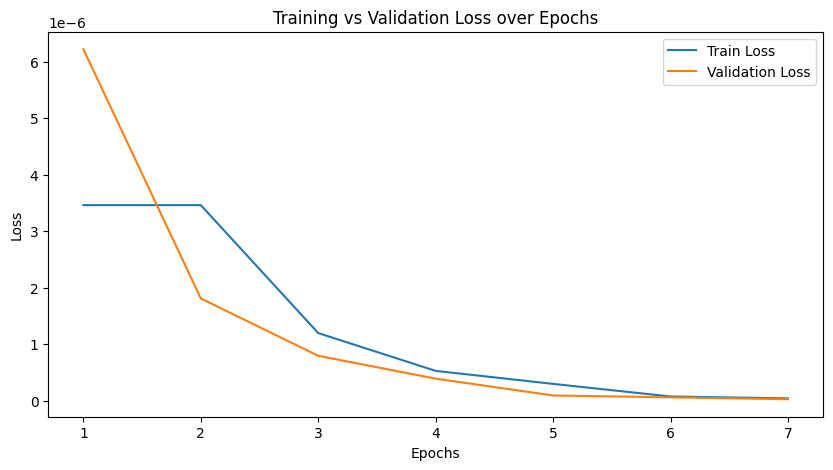

In [13]:
# manually editing train_losses[0] to be able to see the graph

training_losses[0] = training_losses[1]

import matplotlib.pyplot as plt
# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss over Epochs')
plt.legend()
plt.show()

# DEMO

In [35]:
import os

def save_checkpoint(model, filepath=None, default_dir="/content/drive/MyDrive/NLP_PJ", default_filename="sks_model_checkpoint.pth"):

    if filepath is None or not os.path.exists(os.path.dirname(filepath)):
        # Create the default directory if it doesn't exist
        os.makedirs(default_dir, exist_ok=True)
        filepath = os.path.join(default_dir, default_filename)

    checkpoint = {
        'state_dict': model.state_dict()
    }

    torch.save(checkpoint, filepath)
    print("Model checkpoint saved successfully at:", filepath)

def load_checkpoint(model_class, filepath="/content/drive/MyDrive/NLP_PJ/sks_model_checkpoint.pth", device=torch.device("cpu")):
    checkpoint = torch.load(filepath, map_location=device)

    model = model_class(
        max_seq_length=checkpoint['max_seq_length'],
        num_categories=checkpoint['num_categories'],
        embedding_dim=checkpoint['embedding_dim'],
        num_heads=checkpoint['num_heads'],
        d_model=checkpoint['d_model'],
        num_tasks=checkpoint['num_tasks']
    )
    model.load_state_dict(checkpoint['state_dict'])

    print("Model checkpoint loaded successfully.")

    return model



In [36]:
save_checkpoint(model)

Model checkpoint saved successfully at: /content/drive/MyDrive/NLP_PJ/sks_model_checkpoint.pth


In [ ]:
test_dataset = CustomDataset(test_data, max_seq_length=25)

test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch)

In [ ]:
loaded_model = load_checkpoint(SKSTModel)
weighted_f1, macro_f1 = calculate_f1_score(loaded_model, test_loader, device)